In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
# Generate new synthetic 5-class dataset

num_classes = 5
points_per_class = 200
input_dim = 2
N = num_classes * points_per_class

new_means = [
    [1, 1],
    [4, -1],
    [-4, 0],
    [0, 5],
    [-2, -4]
]

std_values = [0.6, 0.9, 0.5, 0.8, 0.7]

X_list = []
y_list = []

for class_id in range(num_classes):
    mean = new_means[class_id]
    std = std_values[class_id]

    X_class = np.random.randn(points_per_class, 2) * std + mean

    angle = np.random.uniform(-0.5, 0.5)
    rot_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                           [np.sin(angle),  np.cos(angle)]])

    X_class = X_class @ rot_matrix

    y_class = np.full(points_per_class, class_id, dtype=int)

    X_list.append(X_class)
    y_list.append(y_class)

X = np.vstack(X_list)
y = np.hstack(y_list)

indices = np.random.permutation(N)
X = X[indices]
y = y[indices]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))


X shape: (1000, 2)
y shape: (1000,)
Unique classes: [0 1 2 3 4]


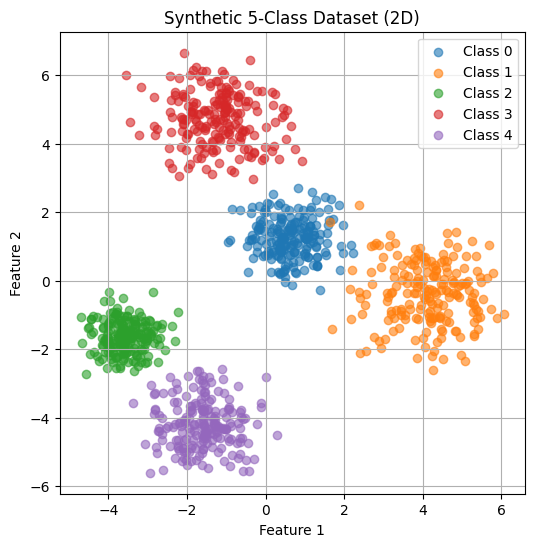

In [5]:
# Visualize synthetic dataset (scatter plot)

plt.figure(figsize=(6, 6))
for c in range(num_classes):
    plt.scatter(X[y == c, 0], X[y == c, 1], label=f"Class {c}", alpha=0.6)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Synthetic 5-Class Dataset (2D)")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Train–test split (80% train, 20% test)

train_ratio = 0.8
train_size = int(train_ratio * N)

X_train = X[:train_size]
y_train = y[:train_size]
X_test  = X[train_size:]
y_test  = y[train_size:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 800
Test size : 200


In [7]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [8]:
# One-hot encode labels for training

Y_train_oh = one_hot_encode(y_train, num_classes)
Y_test_oh  = one_hot_encode(y_test, num_classes)

print("Y_train_oh shape:", Y_train_oh.shape)
print("Y_test_oh shape :", Y_test_oh.shape)


Y_train_oh shape: (800, 5)
Y_test_oh shape : (200, 5)


In [9]:
# Three-hidden-layer Neural Network

class NeuralNetwork(object):
    def __init__(self, input_dim, h1, h2, h3, output_dim, learning_rate=0.05):
        self.input_dim = input_dim
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.output_dim = output_dim

        self.learning_rate = learning_rate

        self.W1 = np.random.randn(input_dim, h1) * 0.1
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * 0.1
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * 0.1
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * 0.1
        self.b4 = np.zeros((1, output_dim))

    def sigmoid(self, x):

        return 1.0 / (1.0 + np.exp(-x))

    def sigmoid_derivative(self, sig_x):

        return sig_x * (1.0 - sig_x)

    def softmax(self, z):
        z_stable = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_stable)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def feed_forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)

        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.sigmoid(self.z3)

        self.z4 = np.dot(self.a3, self.W4) + self.b4
        self.y_pred = self.softmax(self.z4)

        return self.y_pred

    def compute_loss(self, Y_true_one_hot, Y_pred_prob):

        m = Y_true_one_hot.shape[0]
        eps = 1e-12
        log_probs = np.log(Y_pred_prob + eps)
        loss = -np.sum(Y_true_one_hot * log_probs) / m
        return loss

    def back_propagation(self, X, Y_true_one_hot):

        m = X.shape[0]

        dz4 = (self.y_pred - Y_true_one_hot) / m
        dW4 = np.dot(self.a3.T, dz4)
        db4 = np.sum(dz4, axis=0, keepdims=True)

        da3 = np.dot(dz4, self.W4.T)
        dz3 = da3 * self.sigmoid_derivative(self.a3)
        dW3 = np.dot(self.a2.T, dz3)
        db3 = np.sum(dz3, axis=0, keepdims=True)

        da2 = np.dot(dz3, self.W3.T)
        dz2 = da2 * self.sigmoid_derivative(self.a2)
        dW2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.sigmoid_derivative(self.a1)
        dW1 = np.dot(X.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        lr = self.learning_rate
        self.W4 -= lr * dW4
        self.b4 -= lr * db4

        self.W3 -= lr * dW3
        self.b3 -= lr * db3

        self.W2 -= lr * dW2
        self.b2 -= lr * db2

        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    def train(self, X, Y_true_one_hot, epochs=1000, print_every=25):

        loss_history = []

        for epoch in range(1, epochs + 1):
            y_pred_prob = self.feed_forward(X)

            loss = self.compute_loss(Y_true_one_hot, y_pred_prob)
            loss_history.append(loss)

            self.back_propagation(X, Y_true_one_hot)

            if epoch % print_every == 0:
                print(f"Epoch {epoch}/{epochs} - Loss: {loss:.4f}")

        return loss_history

    def predict(self, X):
        probs = self.feed_forward(X)
        return np.argmax(probs, axis=1)


In [12]:
h1 = 10
h2 = 20
h3 = 10

nn = NeuralNetwork(
    input_dim=input_dim,
    h1=h1,
    h2=h2,
    h3=h3,
    output_dim=num_classes,
    learning_rate=0.01
)

epochs = 1000
loss_history = nn.train(X_train, Y_train_oh, epochs=epochs, print_every=50)


Epoch 50/1000 - Loss: 1.6138
Epoch 100/1000 - Loss: 1.6110
Epoch 150/1000 - Loss: 1.6097
Epoch 200/1000 - Loss: 1.6091
Epoch 250/1000 - Loss: 1.6087
Epoch 300/1000 - Loss: 1.6086
Epoch 350/1000 - Loss: 1.6085
Epoch 400/1000 - Loss: 1.6085
Epoch 450/1000 - Loss: 1.6085
Epoch 500/1000 - Loss: 1.6084
Epoch 550/1000 - Loss: 1.6084
Epoch 600/1000 - Loss: 1.6084
Epoch 650/1000 - Loss: 1.6084
Epoch 700/1000 - Loss: 1.6084
Epoch 750/1000 - Loss: 1.6084
Epoch 800/1000 - Loss: 1.6084
Epoch 850/1000 - Loss: 1.6084
Epoch 900/1000 - Loss: 1.6084
Epoch 950/1000 - Loss: 1.6084
Epoch 1000/1000 - Loss: 1.6084


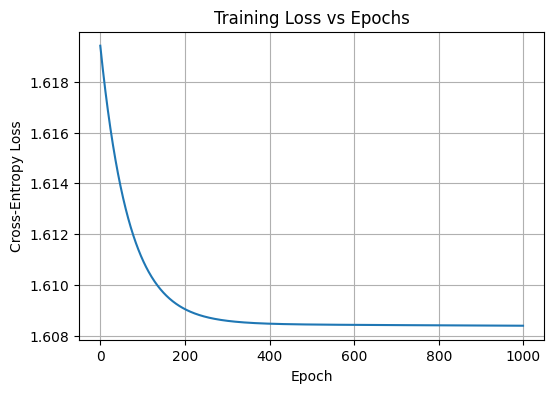

In [13]:
# Visualize training loss

plt.figure(figsize=(6, 4))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.show()


In [14]:
y_pred_test = nn.predict(X_test)

print("First 10 predictions:", y_pred_test[:10])
print("First 10 true labels:", y_test[:10])


def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

acc = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {acc:.4f}")


First 10 predictions: [0 0 0 0 0 0 0 0 0 0]
First 10 true labels: [1 1 2 1 2 3 1 3 3 1]
Test Accuracy: 0.1600


In [16]:
# Precision, Recall, F1

def precision_recall_f1(y_true, y_pred, num_classes):
    precisions = []
    recalls = []
    f1s = []

    for c in range(num_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))

        precision = tp / (tp + fp + 1e-12)
        recall    = tp / (tp + fn + 1e-12)
        f1        = 2 * precision * recall / (precision + recall + 1e-12)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    macro_precision = np.mean(precisions)
    macro_recall    = np.mean(recalls)
    macro_f1        = np.mean(f1s)

    return np.array(precisions), np.array(recalls), np.array(f1s), \
           macro_precision, macro_recall, macro_f1

precisions, recalls, f1s, macro_p, macro_r, macro_f1 = precision_recall_f1(
    y_test, y_pred_test, num_classes
)

for c in range(num_classes):
    print(f"Class {c}: Precision={precisions[c]:.3f}, Recall={recalls[c]:.3f}, F1={f1s[c]:.3f}")

print(f"Macro Precision: {macro_p:.3f}")
print(f"Macro Recall   : {macro_r:.3f}")
print(f"Macro F1-score : {macro_f1:.3f}")


Class 0: Precision=0.160, Recall=1.000, F1=0.276
Class 1: Precision=0.000, Recall=0.000, F1=0.000
Class 2: Precision=0.000, Recall=0.000, F1=0.000
Class 3: Precision=0.000, Recall=0.000, F1=0.000
Class 4: Precision=0.000, Recall=0.000, F1=0.000
Macro Precision: 0.032
Macro Recall   : 0.200
Macro F1-score : 0.055


Confusion Matrix (rows=true, cols=pred):
[[32  0  0  0  0]
 [38  0  0  0  0]
 [49  0  0  0  0]
 [48  0  0  0  0]
 [33  0  0  0  0]]


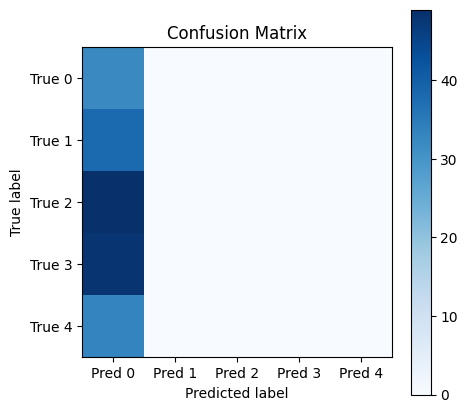

In [17]:
# Confusion matrix

conf_mat = np.zeros((num_classes, num_classes), dtype=int)
for yt, yp in zip(y_test, y_pred_test):
    conf_mat[yt, yp] += 1

print("Confusion Matrix (rows=true, cols=pred):")
print(conf_mat)

plt.figure(figsize=(5, 5))
plt.imshow(conf_mat, cmap="Blues")
plt.colorbar()
plt.xticks(range(num_classes), [f"Pred {i}" for i in range(num_classes)])
plt.yticks(range(num_classes), [f"True {i}" for i in range(num_classes)])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()
